In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_dataset = pd.read_csv('Train_Data.csv')
test_dataset = pd.read_csv('Test_Data.csv')
cv_dataset = pd.read_csv('CV_Data.csv')

In [7]:
train_dataset.shape, test_dataset.shape, cv_dataset.shape

((2758, 4), (399, 4), (550, 4))

In [8]:
cv_dataset.head()

,Person_id,Image1,Image2,Report
0,Scanned Images/CXR3690_IM-1841_0,Scanned Images/CXR3690_IM-1841-1001.png,Scanned Images/CXR3690_IM-1841-2001.png,startseq the heart again enlarged . aorta tor...
1,Scanned Images/CXR3691_IM-1842_0,Scanned Images/CXR3691_IM-1842-1001.png,Scanned Images/CXR3691_IM-1842-3003.png,startseq the heart normal size . the mediasti...
2,Scanned Images/CXR3692_IM-1843_0,Scanned Images/CXR3692_IM-1843-1001.png,Scanned Images/CXR3692_IM-1843-2001.png,startseq stable cardiomediastinal silhouette ....
3,Scanned Images/CXR3693_IM-1844_0,Scanned Images/CXR3693_IM-1844-1001.png,Scanned Images/CXR3693_IM-1844-1002.png,startseq the lungs are clear bilaterally . sp...
4,Scanned Images/CXR3694_IM-1845_0,Scanned Images/CXR3694_IM-1845-1001.png,Scanned Images/CXR3694_IM-1845-2001.png,startseq interval removal leftsided chest tube...


In [9]:
pad_size = 153   # Max length

In [11]:
X_train, X_test, X_cv = train_dataset['Person_id'], test_dataset['Person_id'], cv_dataset['Person_id'][:546]
y_train, y_test, y_cv = train_dataset['Report'], test_dataset['Report'], cv_dataset['Report'][:546]

In [12]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [14]:
f = open('Image_features_enc-dec.pickle','rb') # contains the features from chexNet
Xnet_Features = pickle.load(f)
f.close()

In [15]:
f = open('GLOVE_VECTORS.pickle','rb') # 300d glove vectors  
glove_vectors = pickle.load(f)
f.close()

In [16]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [17]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [18]:
BATCH_SIZE = 14

In [19]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = Xnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [20]:
def create_dataset(img_name, caption):
  
    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [21]:
train_generator = create_dataset(X_train, y_train)
cv_generator = create_dataset(X_cv, y_cv)

In [22]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [23]:
def convert(images, reports):
    '''This function takes the batch of data and converts them into a new dataset(A WORD BY WORD DATASET)'''
    imgs = []
    in_reports = []
    out_reports = []
    for i in range(len(images)):
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]
      #  print(sequence)
        for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
          #  print(in_seq)
            in_reports.append(in_seq)
           # print(out_seq)
            out_reports.append(out_seq)
        
    return np.array(imgs), np.array(in_reports), np.array(out_reports)

In [24]:
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
random.seed(12)

In [25]:
input1 = Input(shape=(2048), name='Image_1')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153), name='Text_Input')
emb_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="Embedding_layer")
emb = emb_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 153)]        0                                            
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 153, 300)     428100      Text_Input[0][0]                 
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 153, 256)     570368      Embedding_layer[0][0]            
__________________________________________________________________________________________________
Image_1 (InputLayer)            [(None, 2048)]       0                                            
______________________________________________________________________________________________

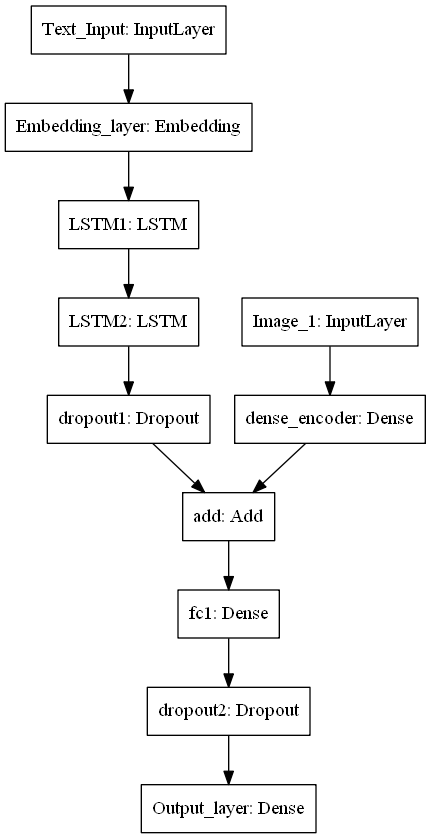

In [26]:
tf.keras.utils.plot_model(encoder_decoder)

In [56]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [57]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [58]:
encoder_decoder.compile(optimizer, loss = maskedLoss)

In [59]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

## Training for epochs 1-20

In [60]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img, report in train_generator:
       
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train.shape[0]//14)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    
    for img, report in cv_generator:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv.shape[0]//14)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    encoder_decoder.save_weights('Weights_re/encoder_decoder_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  1
Training Loss: 0.003326163182819858,  Val Loss: 0.0029444520194561053
Time Taken for this Epoch : 95.27918720245361 sec
EPOCH :  2
Training Loss: 0.0026811409746367617,  Val Loss: 0.0022076617878599046
Time Taken for this Epoch : 42.68967032432556 sec
EPOCH :  3
Training Loss: 0.0020950774651559705,  Val Loss: 0.0018281425403144497
Time Taken for this Epoch : 42.113810777664185 sec
EPOCH :  4
Training Loss: 0.0018133486320883944,  Val Loss: 0.0016427363585441923
Time Taken for this Epoch : 42.319337368011475 sec
EPOCH :  5
Training Loss: 0.0016522072882008583,  Val Loss: 0.0015351673026975149
Time Taken for this Epoch : 42.39927816390991 sec
EPOCH :  6
Training Loss: 0.0015360610612767376,  Val Loss: 0.0014780913658726674
Time Taken for this Epoch : 42.14148163795471 sec
EPOCH :  7
Training Loss: 0.0014560442328627981,  Val Loss: 0.0014122874022294313
Time Taken for this Epoch : 42.032474994659424 sec
EPOCH :  8
Training Loss: 0.0013832337344727161,  Val Loss: 0.001361846144

In [27]:
encoder_decoder.load_weights('Weights_re/encoder_decoder_epoch_20.h5')

## Inference Setup

In [30]:
# encoder
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder# 
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

### Greedy Search

In [62]:
def greedysearch(img):
    image = Xnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

# Eg: 1

In [74]:
res36 = greedysearch(X_cv.values[36]) # result after 20 epochs
res36

'the heart size and mediastinal contours appear within normal limits . pulmonary vascularity within normal limits . no focal consolidation pleural effusion pneumothora identified . no acute bony abnormality .'

In [75]:
y_cv.values[36]  # original

'startseq the lungs are clear .  heart size normal .  no pneumothora .  endseq'

# Eg: 2

In [77]:
res72 = greedysearch(X_cv.values[72]) # result after 20 epochs
res72

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [78]:
y_cv.values[72] # original

'startseq the heart size and pulmonary vascularity appear within normal limits .  the lungs are free focal airspace disease .  no pleural effusion pneumothora seen .  no noncalcified nodules are identified .  endseq'

# Eg: 3

In [79]:
res108 = greedysearch(X_cv.values[108])  # result after 20 epochs
res108

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [80]:
y_cv.values[108] # original

'startseq the heart normal size .  the pulmonary vascularity within normal limits appearance .  no pneumothora pleural effusion .  patchy right lower lung opacification noted .  endseq'

# Eg: 4

In [82]:
res37 = greedysearch(X_train.values[37])  # result after 20 epochs
res37

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [83]:
y_train.values[37] # original

'startseq the cardiomediastinal silhouette and pulmonary vasculature are within normal limits .  there no pneumothora pleural effusion .  there are no focal areas consolidation .  there are calcifications projecting the left midlung unchanged from prior this sequela prior granulomatous disease .  there are small tspine osteophytes .  endseq'

# Eg: 5

In [85]:
res0 = greedysearch(X_train.values[0]) # result after 20 epochs
res0

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [87]:
y_train.values[0] # original

'startseq the cardiac silhouette and mediastinum size are within normal limits .  there no pulmonary edema .  there no focal consolidation .  there are no pleural effusion .  there no evidence pneumothora .  endseq'

## BLEU SCORE

In [98]:
def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

## CV BLEU

In [99]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

546it [07:07,  1.28it/s]


In [101]:
print('Bleu1 Score: ', sum(bleu1)/X_cv.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv.shape[0])

Bleu1 Score:  0.3300338662017445
Bleu2 Score:  0.2078214228248296
Bleu3 Score:  0.12100037284585875
Bleu4 Score:  0.04276169898014262


## Test BLEU

In [67]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_test.values, y_test.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

399it [06:35,  1.01it/s]


In [68]:
print('Bleu1 Score: ', sum(bleu1)/X_test.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_test.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_test.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_test.shape[0])

Bleu1 Score:  0.3440858945560657
Bleu2 Score:  0.21814823127504135
Bleu3 Score:  0.12983146064760928
Bleu4 Score:  0.053968944497224


### Beam Search

In [36]:
def beamsearch(image, beam_width):
    
    start = [tokenizer.word_index['startseq']]

    sequences = [[start, 0]]
    
    img_features = Xnet_Features[image]
    img_features = encoder_model.predict(img_features)
    finished_seq = []
    
    for i in range(153):
        all_candidates = []
        new_seq = []
        for s in sequences:

            text_input = pad_sequences([s[0]], 153, padding='post')
            predictions = decoder_model.predict([text_input,img_features])
            top_words = np.argsort(predictions[0])[-beam_width:]
            seq, score = s
            
            for t in top_words:
                candidates = [seq + [t], score - np.log(predictions[0][t])]
                all_candidates.append(candidates)
                
        sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
        # checks for 'endseq' in each seq in the beam
        count = 0
        for seq,score in sequences:
            if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                score = score/len(seq)   # normalized
                finished_seq.append([seq, score])
                count+=1
            else:
                new_seq.append([seq, score])
        beam_width -= count
        sequences = new_seq
        
        # if all the sequences reaches its end before 155 timesteps
        if not sequences:
            break
        else:
            continue
        
    sequences = finished_seq[-1] 
    rep = sequences[0]
    score = sequences[1]
    temp = []
    rep.pop(0)
    for word in rep:
        if word != tokenizer.word_index['endseq']:
            temp.append(tokenizer.index_word[word])
        else:
            break    
    rep = ' '.join(e for e in temp)        
    
    return rep, score

# Example 1

In [37]:
res0 = beamsearch(X_cv.values[0], 5) # beam_width = 5 
res0

('the cardiomediastinal silhouette and pulmonary vasculature are within normal limits size . the lungs are clear focal airspace disease pneumothora pleural effusion . there are no acute bony findings .',
 0.17186643741274565)

In [40]:
res0 = beamsearch(X_cv.values[0], 7)  # beam_width = 7
res0

('the cardiomediastinal silhouette and pulmonary vasculature are within normal limits size . the lungs are clear focal airspace disease pneumothora pleural effusion . there are no acute bony findings .',
 0.17186643741274565)

In [42]:
y_cv.values[0]  # original

'startseq the heart again enlarged .  aorta tortuous .  the lungs are hypoinflated but clear .  no pleural effusion pneumothora seen .  endseq'

### You can try with other examples